In [22]:
import goodfire
from openai import OpenAI
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
load_dotenv()

GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")

In [8]:
from steering_test_cases import SAMPLE_STEERING_QUERIES
for i in range(len(SAMPLE_STEERING_QUERIES)):

    print(SAMPLE_STEERING_QUERIES[0].test_prompt_messages)
    print(SAMPLE_STEERING_QUERIES[0].test_prompt_messages[i])
    print(SAMPLE_STEERING_QUERIES[0].test_prompt_messages[i][0])
    print(SAMPLE_STEERING_QUERIES[0].test_prompt_messages[i][0]['content'])

[[{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Explain quantum physics'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Give me a recipe for chocolate cake'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Tell me about the history of Rome'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Write a condolence message'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Explain a serious medical condition'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Create a recipe for happiness'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Explain evolution in simple terms'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'How do

In [ ]:
variant = goodfire.Variant(
    base_model='meta-llama/Llama-3.3-70B-Instruct'
)
client = OpenAI(
    api_key=GOODFIRE_API_KEY,
    base_url="https://api.goodfire.ai/api/inference/v1"
)

response = client.chat.completions.create(
    messages=[{"role": "user", "content": "Hello. What is your name?"}],
    model=variant.base_model,
    extra_body={"controller": variant.controller.json()},
    response_format="json",
)
response

ChatCompletion(id='chatcmpl-039b5ce1-ef0f-484b-9408-a67148f1f2ff', choices=[Choice(finish_reason=None, index=0, logprobs=None, message=ChatCompletionMessage(content='I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1736952321, model='meta-llama/Llama-3.3-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint='fp_goodfire', usage=None, gf_event_names=None)

In [11]:
client = goodfire.Client(api_key=GOODFIRE_API_KEY)
client.chat.completions.create(
    messages=[{"role": "user", "content": "Hello. What is your name?"}],
    model=variant.base_model,
)

ChatCompletion(id='chatcmpl-e378728f-d98b-46a9-a39c-a264c99c3bf5', object='chat.completion', created=1736953855, model='meta-llama/Llama-3.3-70B-Instruct', system_fingerprint='fp_goodfire', gf_event_names=None, choices=[ChatCompletionChoice(index=0, message={'role': 'assistant', 'content': "Hello. I'm an assistant, and I don't have a personal name, but I'm here to help you with any questions or tasks you might have. How can I assist you today?"}, finish_reason=None)])

# Checking results

In [17]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# load results
results_df = pd.read_csv('evaluation_results.csv')
results_df.sample(5)

query  \
50  be educational and explain like a teacher   
52  be educational and explain like a teacher   
43               be empathetic and supportive   
15                 be professional and formal   
3                                    be funny   

                                   prompt  \
50       How does the immune system work?   
52                What is climate change?   
43                Debug this code snippet   
15  What's the best way to clean windows?   
3              Write a condolence message   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Results

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_all_methods(df: pd.DataFrame, save_path: str = None):
    """
    Create a grid of plots showing point-error plots and score distributions
    for each steering method in the dataframe.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Get unique methods
    methods = df['steering_method'].unique()
    n_methods = len(methods)
    
    # Set up the figure with a grid
    # 2 rows (point-error and distributions) x n_methods columns
    fig = plt.figure(figsize=(8*n_methods, 12), dpi=100)
    gs = fig.add_gridspec(2, n_methods)
    
    # Colors
    behavior_color = '#3498db'  # Blue
    coherence_color = '#e67e22'  # Orange
    
    # Plot each method
    for idx, method in enumerate(methods):
        method_df = df[df['steering_method'] == method]
        
        # Point-error plot
        ax_point = fig.add_subplot(gs[0, idx])
        plot_method_point_error(method_df, ax_point, behavior_color, coherence_color)
        
        # Distribution plot
        ax_dist = fig.add_subplot(gs[1, idx])
        plot_method_distributions(method_df, ax_dist, behavior_color, coherence_color)
        
        # Add method title
        ax_point.set_title(f'Method: {method}', pad=20, fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Show plot
    plt.show()

def plot_method_point_error(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create point-error plot for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Define query order
    query_order = df_melted['query'].unique()
    df_melted['query'] = pd.Categorical(df_melted['query'], categories=query_order, ordered=True)
    
    # Calculate statistics
    stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
    stats['query'] = pd.Categorical(stats['query'], categories=query_order, ordered=True)
    stats = stats.sort_values('query')
    
    # Add individual points
    sns.stripplot(x='query', 
                 y='score', 
                 hue='metric',
                 data=df_melted,
                 dodge=True,
                 alpha=0.3,
                 zorder=1,
                 size=4,
                 palette=[behavior_color, coherence_color],
                 jitter=0.2,
                 order=query_order,
                 ax=ax)
    
    # Add error bars
    width = 0.2
    for i, metric in enumerate(['behavior', 'coherence']):
        metric_stats = stats[stats['metric'] == metric]
        offset = width if i == 1 else -width
        color = behavior_color if metric == 'behavior' else coherence_color
        
        ax.errorbar(x=np.arange(len(metric_stats)) + offset,
                   y=metric_stats['mean'],
                   yerr=metric_stats['std'],
                   fmt='o',
                   capsize=5,
                   capthick=2,
                   markersize=8,
                   color=color,
                   elinewidth=2,
                   label=metric)
    
    # Customize plot
    ax.set_xlabel('Query Type', fontsize=10, labelpad=10)
    ax.set_ylabel('Score', fontsize=10, labelpad=10)
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Handle legend
    if ax.get_subplotspec().is_last_col():
        ax.legend(title='Metric', title_fontsize=10, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
    else:
        ax.legend().remove()

def plot_method_distributions(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create distribution plots for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Create two subplots within the given axes
    divider = make_axes_locatable(ax)
    ax_behavior = ax
    ax_coherence = divider.append_axes("right", size="100%", pad=0.1)
    
    # Plot behavior scores
    behavior_data = df_melted[df_melted['metric'] == 'behavior']['score']
    ax_behavior.hist(behavior_data, bins=np.arange(0.5, 6, 0.5), 
                    color=behavior_color, alpha=0.7, edgecolor='white',
                    orientation='horizontal')
    ax_behavior.axhline(behavior_data.mean(), color='red', linestyle='dashed', linewidth=2,
                       label=f'Mean: {behavior_data.mean():.2f}')
    ax_behavior.set_title('Behavior', pad=20, fontsize=12)
    ax_behavior.set_ylabel('Score', fontsize=10)
    ax_behavior.set_xlabel('Frequency', fontsize=10)
    ax_behavior.set_ylim(0.5, 5.5)
    ax_behavior.set_xlim(0, len(behavior_data))
    ax_behavior.grid(True, alpha=0.3)
    ax_behavior.legend(loc='upper right', fontsize=8)
    
    # Plot coherence scores
    coherence_data = df_melted[df_melted['metric'] == 'coherence']['score']
    ax_coherence.hist(coherence_data, bins=np.arange(0.5, 6, 0.5),
                     color=coherence_color, alpha=0.7, edgecolor='white',
                     orientation='horizontal')
    ax_coherence.axhline(coherence_data.mean(), color='red', linestyle='dashed', linewidth=2,
                        label=f'Mean: {coherence_data.mean():.2f}')
    ax_coherence.set_title('Coherence', pad=20, fontsize=12)
    ax_coherence.set_xlabel('Frequency', fontsize=10)
    ax_coherence.set_ylim(0.5, 5.5)
    ax_coherence.set_xlim(0, len(coherence_data))
    ax_coherence.set_yticklabels([])
    ax_coherence.grid(True, alpha=0.3)
    ax_coherence.legend(loc='upper right', fontsize=8)


### With llama-3.3 as a judge

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sta

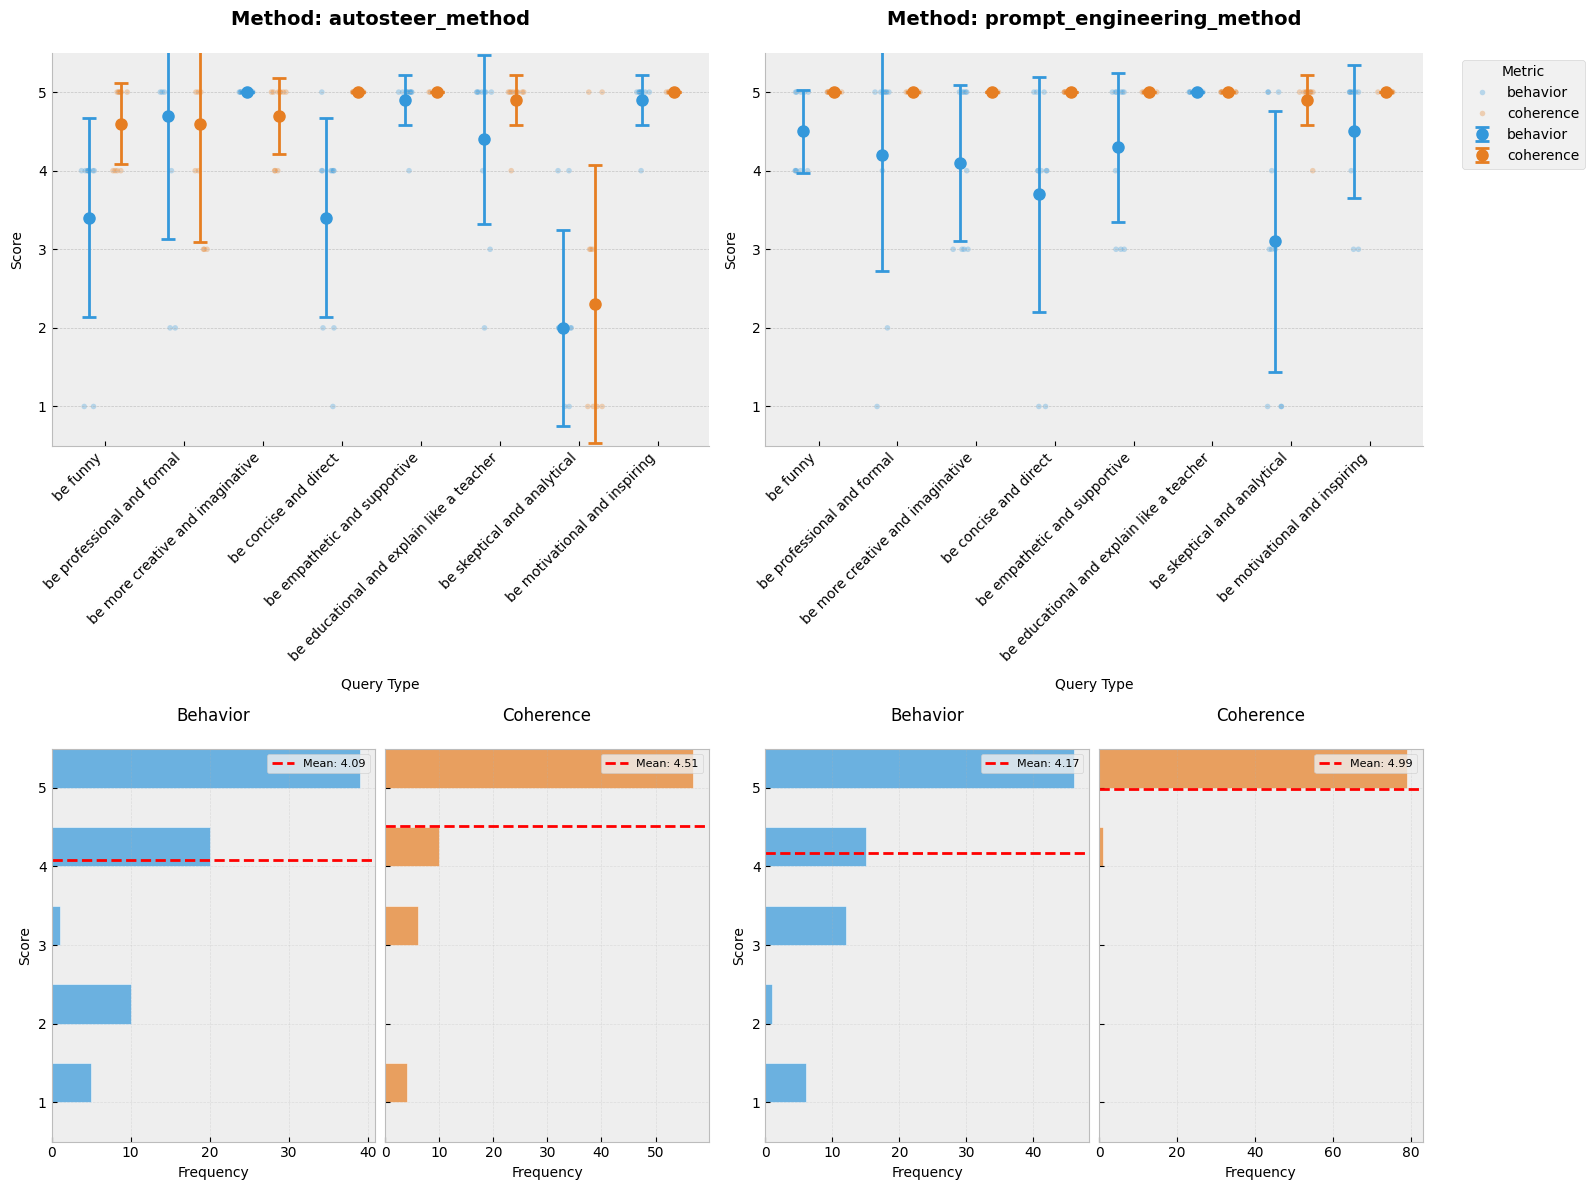

In [159]:
# Load your results
df = pd.read_csv('results/eval_llama-3.3_var_llama-3.1_dt_20250116_1526.csv')

plot_all_methods(df)

In [127]:
# We still get some spurious scores...
print(df['behavior'].value_counts())
print(df['coherence'].value_counts())

behavior
5    85
4    35
3    13
1    11
2    11
6     4
0     1
Name: count, dtype: int64
coherence
5    136
4     11
3      6
1      4
7      2
0      1
Name: count, dtype: int64


### With GPT-4o-mini as a judge

#### Llama-3.1 Variant

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2392575516.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sta

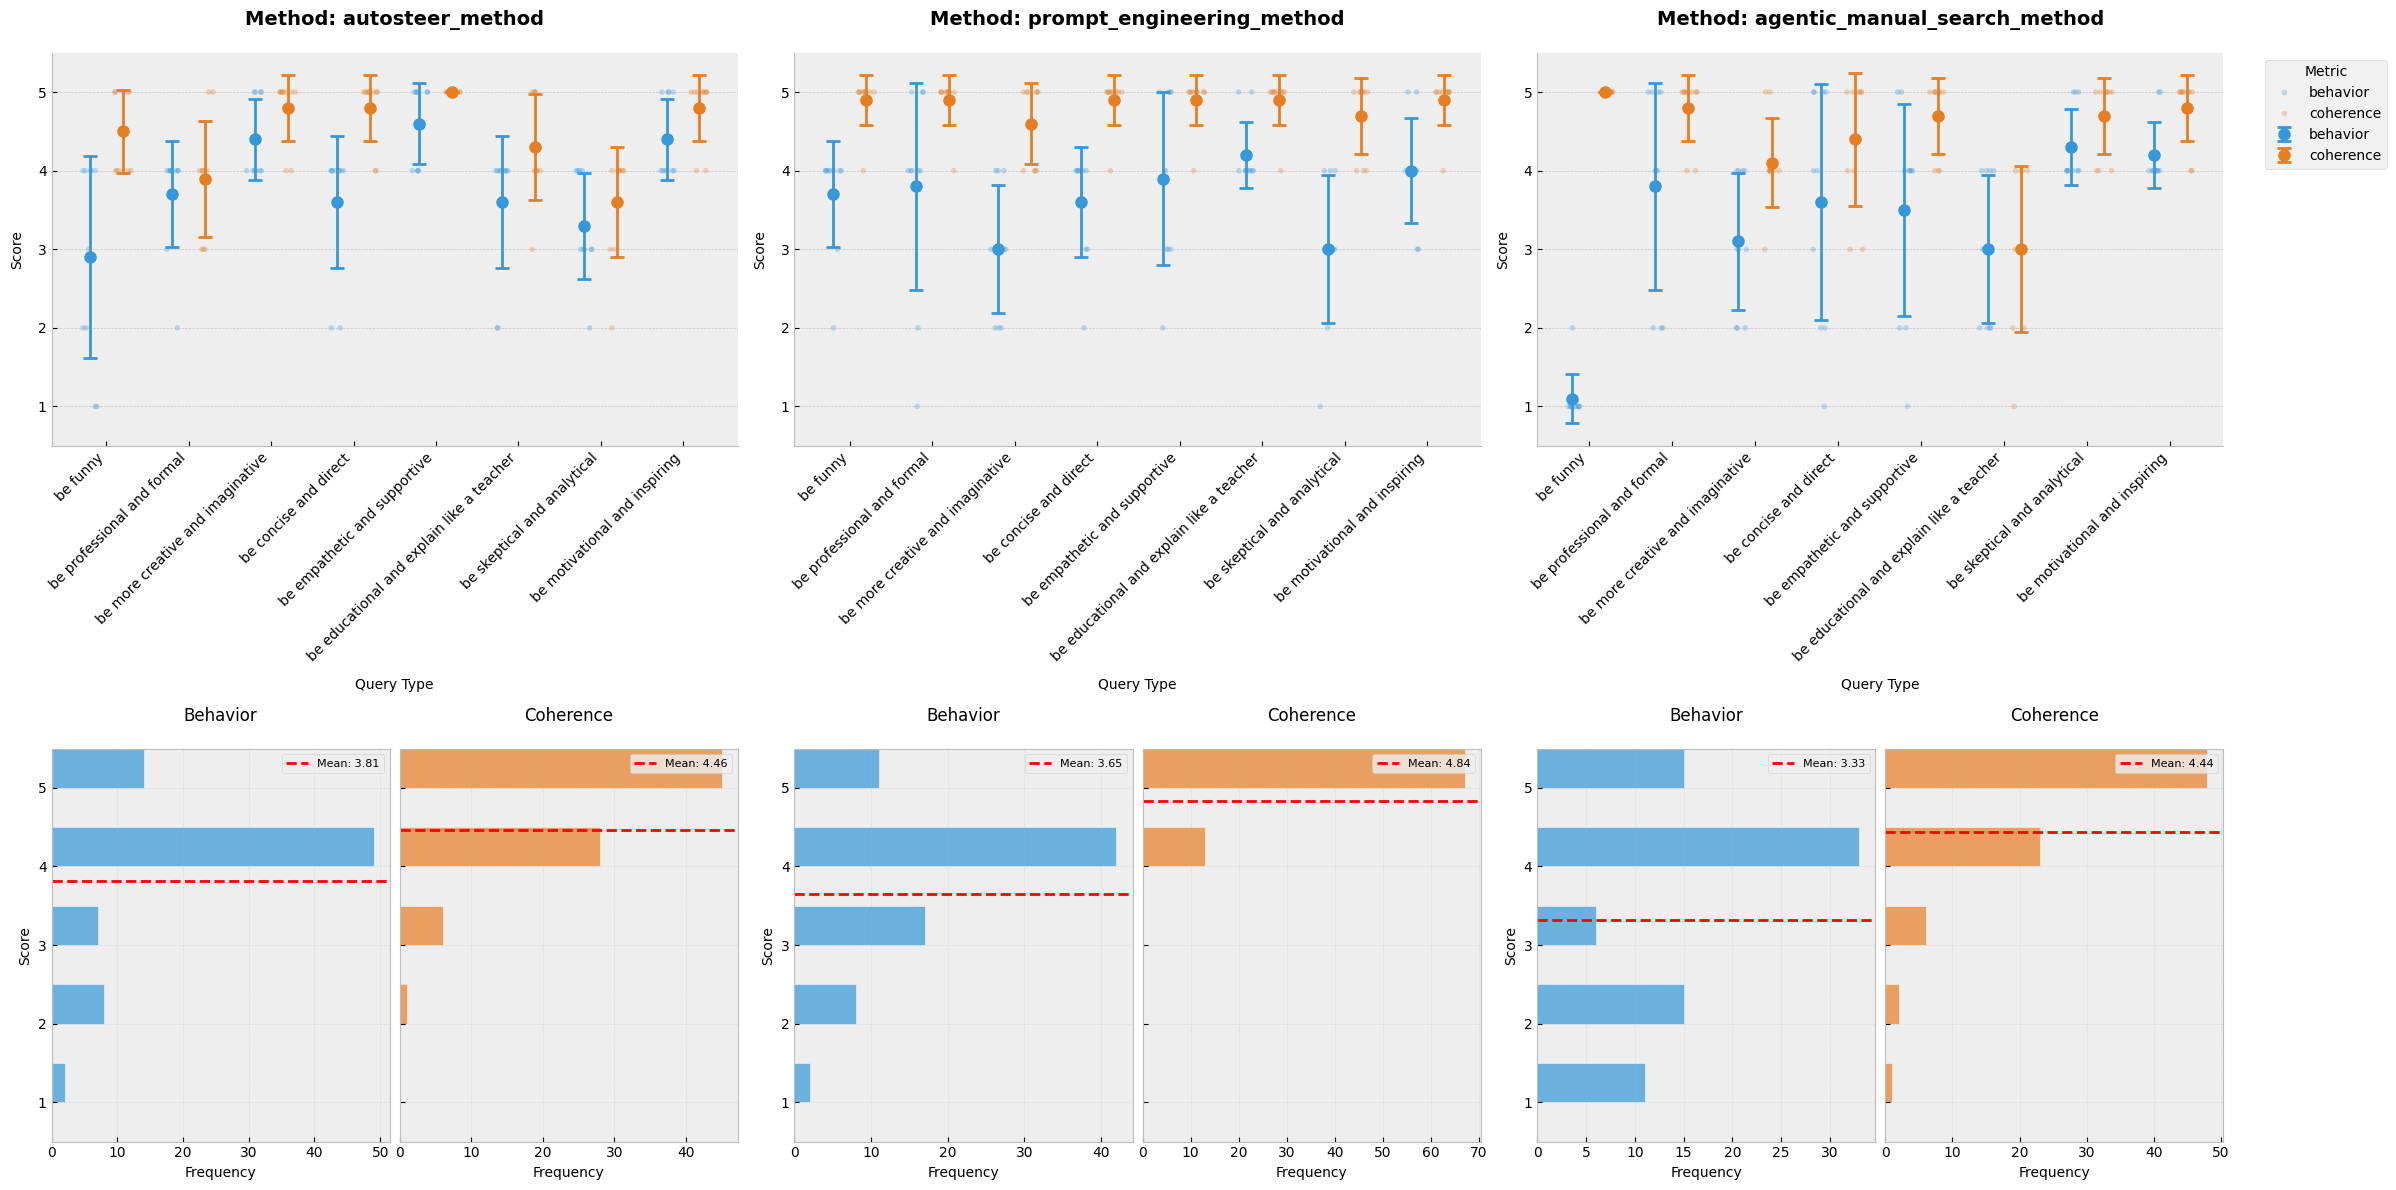

In [185]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.1_dt_20250116_1526.csv')
plot_all_methods(df)

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sta

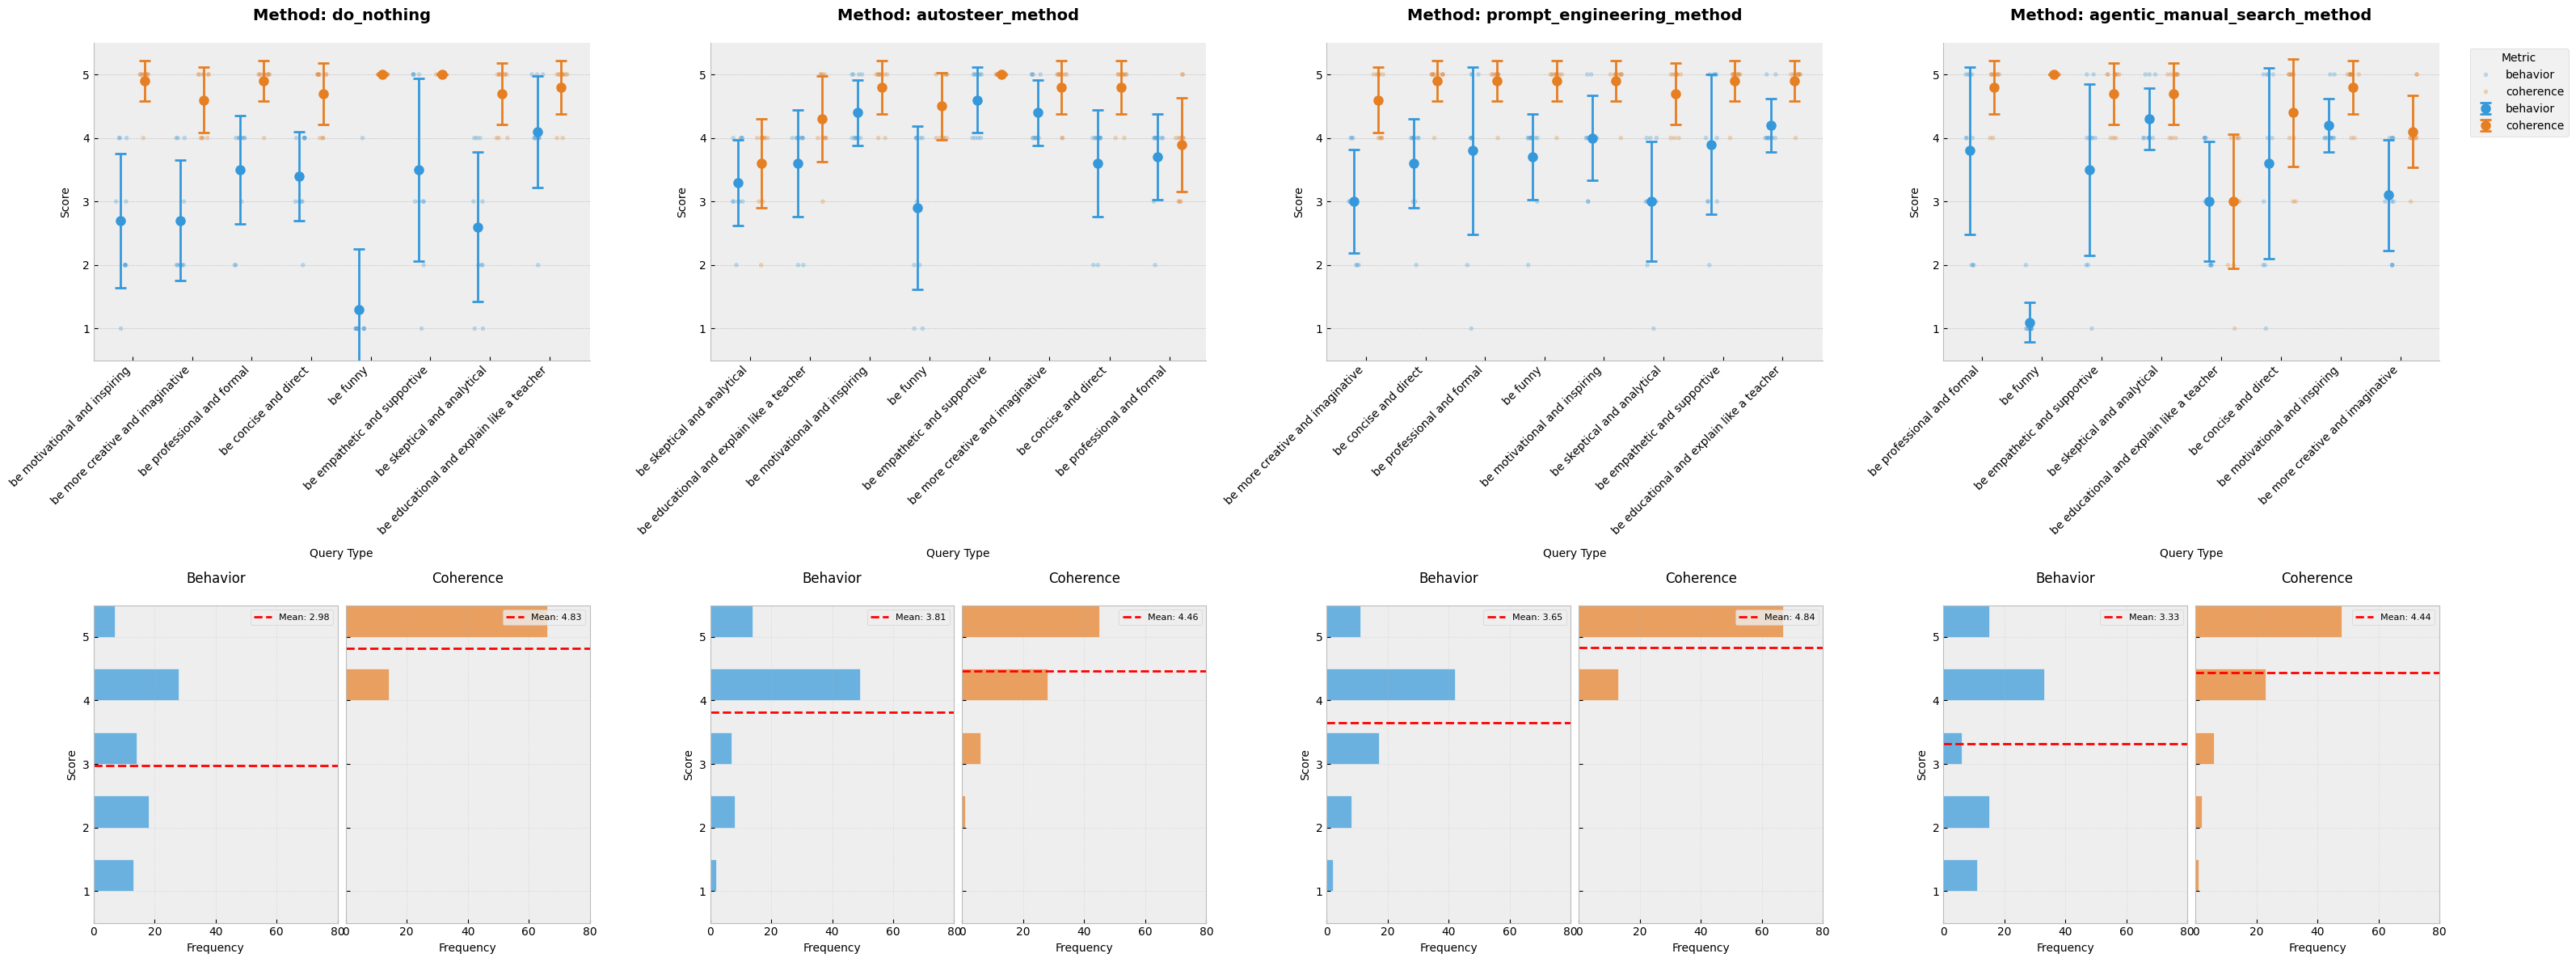

In [206]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.1_dt_20250116_1526.csv')
plot_all_methods(df)

In [108]:
# Check that the score is between 1 and 5
print(df.behavior.value_counts())
print(df.coherence.value_counts())

behavior
4    124
5     40
2     31
3     30
1     15
Name: count, dtype: int64
coherence
5    160
4     64
3     12
2      3
1      1
Name: count, dtype: int64


#### Llama-3.3 Variant

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/1110020032.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sta

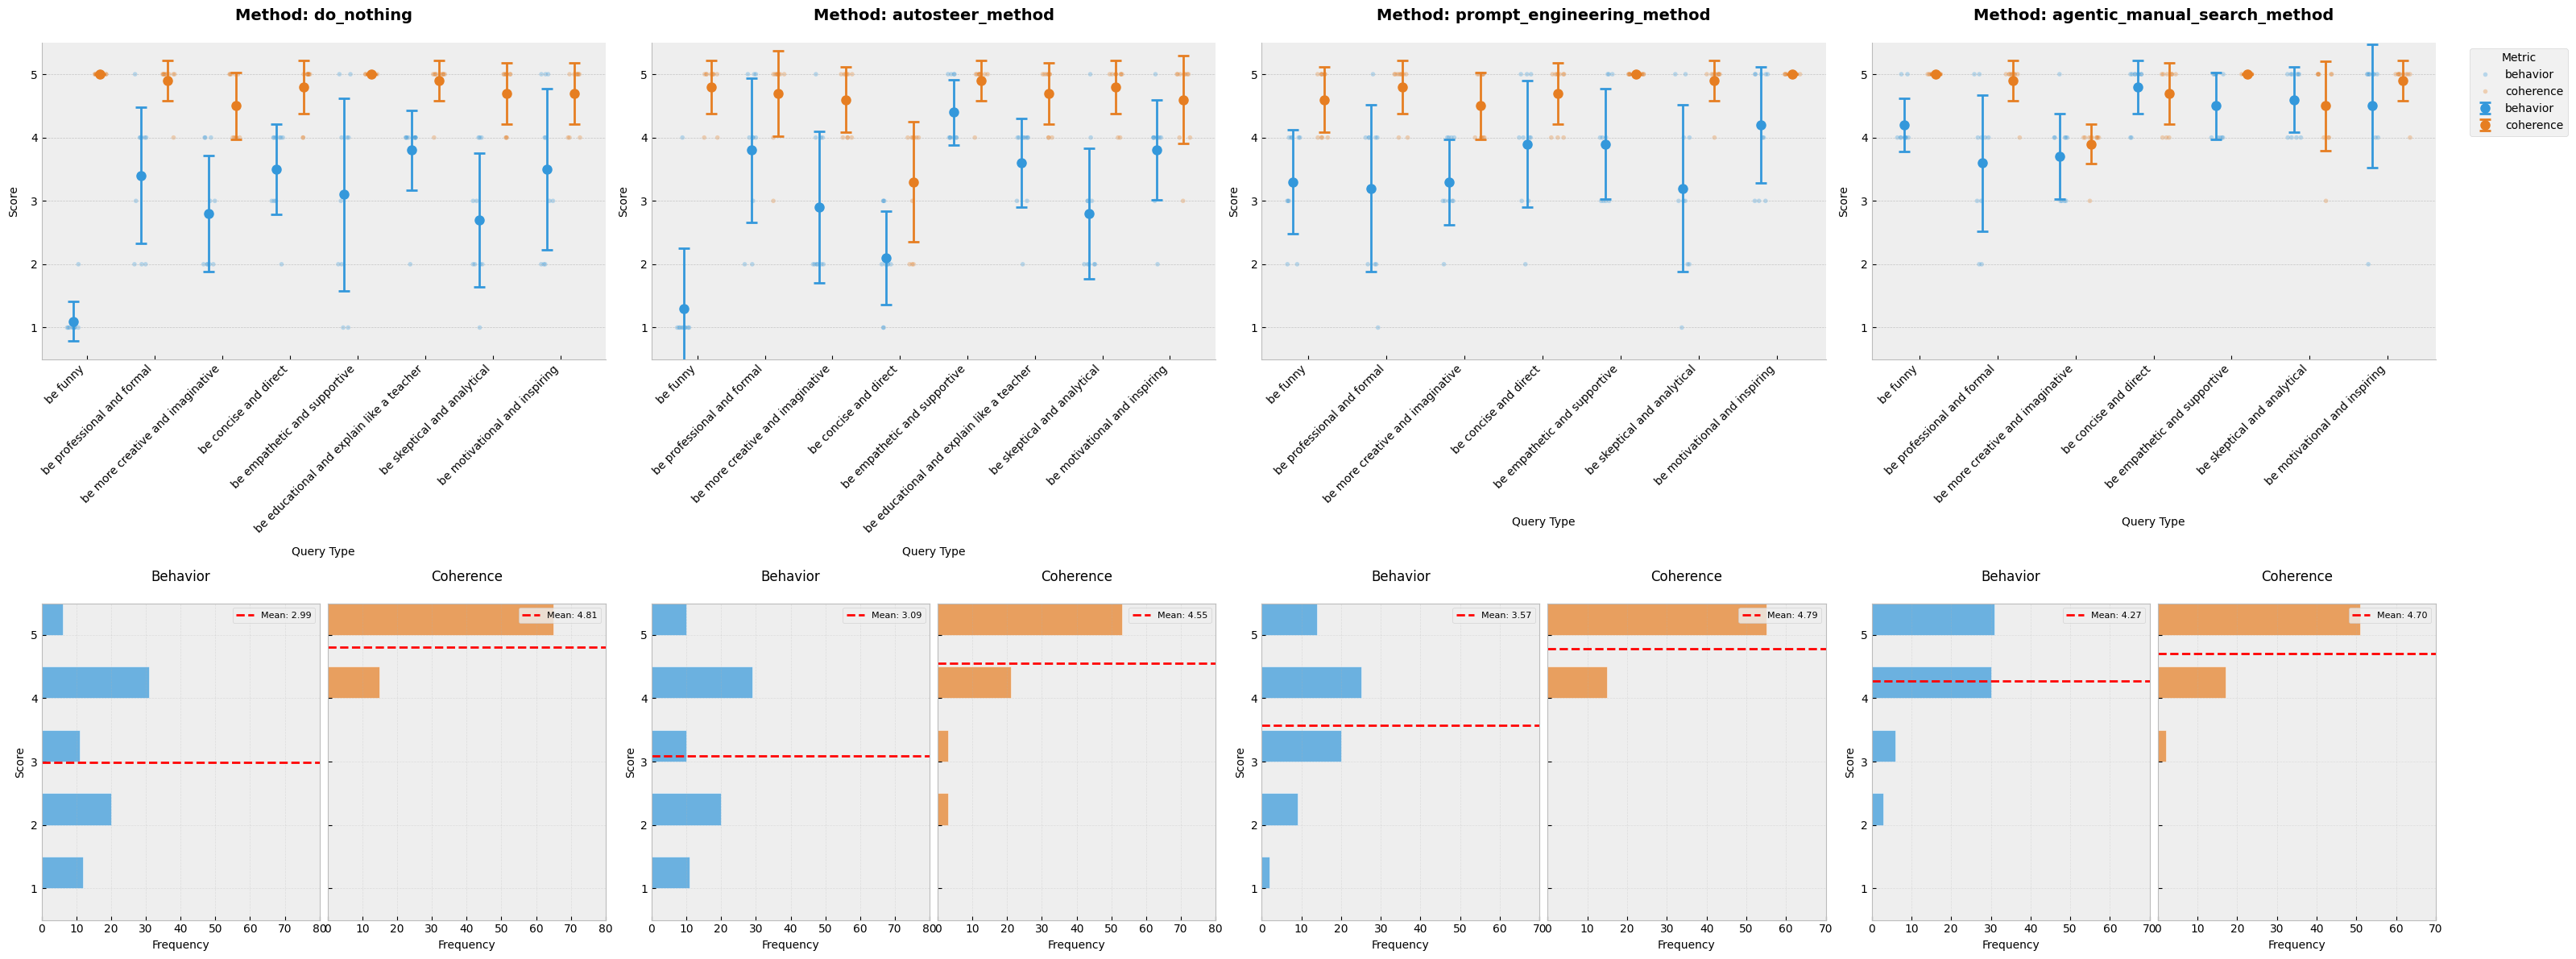

In [204]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.3_dt_20250119_1134.csv')
plot_all_methods(df)

In [168]:
df[df['coherence'] <= 3]

query               steering_method  \
34         be professional and formal              autosteer_method   
84   be more creative and imaginative  agentic_manual_search_method   
92              be concise and direct              autosteer_method   
95              be concise and direct              autosteer_method   
96              be concise and direct              autosteer_method   
97              be concise and direct              autosteer_method   
189       be skeptical and analytical  agentic_manual_search_method   
197     be motivational and inspiring              autosteer_method   

                                                                system_prompt  \
34                                               You are a helpful assistant.   
84   When answering to the following prompt, be more creative and imaginative   
92                                               You are a helpful assistant.   
95                                               You are a helpful assistant.   
96                                               You are a helpful assistant.   
97                                               You are a helpful assistant.   
189       When answering to the following prompt, be skeptical and analytical   
197                                              You are a helpful assistant.   

                                           user_prompt  \
34                                Write a casual tweet   
84                            Write a technical manual   
92          What's the difference between RAM and ROM?   
95                             What is cryptocurrency?   
96   What's the difference between WiFi and Bluetooth?   
97               How does inflation affect daily life?   
189                                 How do planes fly?   
197                                     Tell me a joke   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Plots that don't work yet.

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2944760225.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2944760225.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_7115/2944760225.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sta

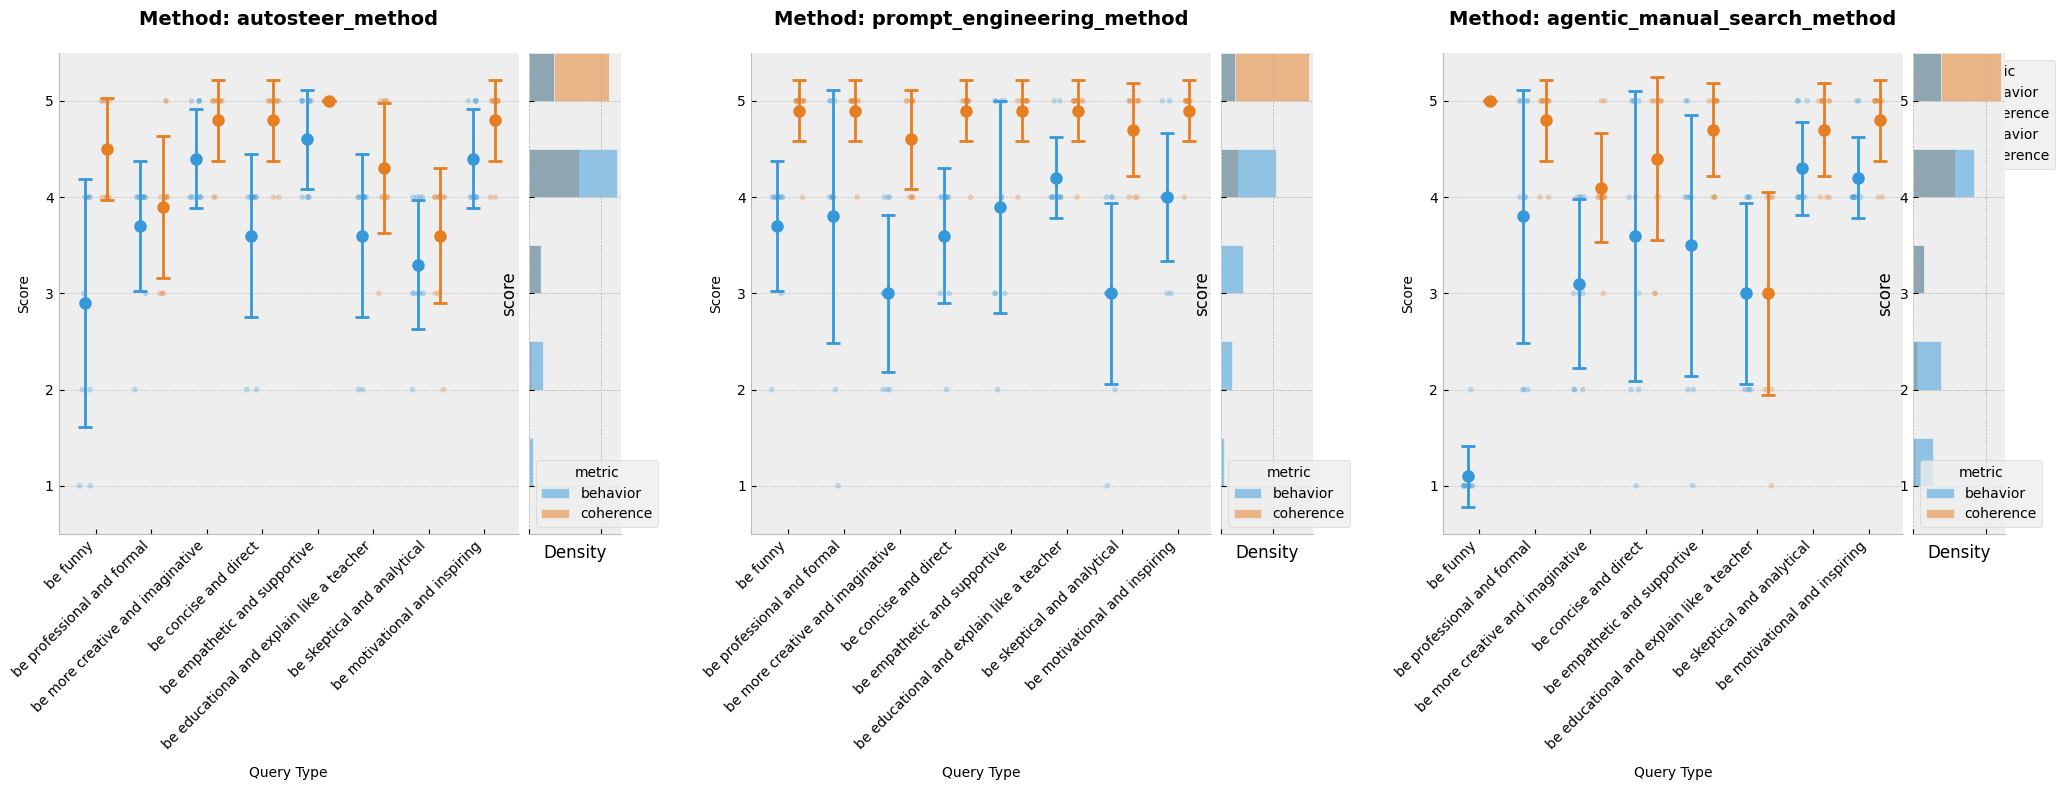

In [157]:
def plot_all_methods(df: pd.DataFrame, save_path: str = None):
    """
    Create a row of plots with marginal distributions on the y-axis
    """
    # Get unique methods
    methods = df['steering_method'].unique()
    n_methods = len(methods)
    
    # Set up the figure
    fig = plt.figure(figsize=(7*n_methods, 8), dpi=100)
    
    # Create a grid with space for marginal distributions
    gs = fig.add_gridspec(1, n_methods, width_ratios=[1]*n_methods)
    
    # Colors
    behavior_color = '#3498db'  # Blue
    coherence_color = '#e67e22'  # Orange
    
    # Plot each method
    for idx, method in enumerate(methods):
        method_df = df[df['steering_method'] == method]
        
        # Create main axis
        ax = fig.add_subplot(gs[0, idx])
        
        # Create marginal axes
        divider = make_axes_locatable(ax)
        ax_marg_y = divider.append_axes("right", size="20%", pad=0.1)
        
        # Plot main point-error plot
        plot_method_point_error(method_df, ax, behavior_color, coherence_color)
        
        # Plot marginal distributions
        plot_marginal_distributions_hist(method_df, ax_marg_y, behavior_color, coherence_color)
        
        # Add method title
        ax.set_title(f'Method: {method}', pad=20, fontsize=14, fontweight='bold')
        
        # Remove y-axis from marginal plot
        ax_marg_y.set_xticklabels([])
        if idx < n_methods - 1:  # Only show y-ticks for the last marginal plot
            ax_marg_y.set_yticklabels([])
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Show plot
    plt.show()

def plot_marginal_distributions_hist(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Plot marginal distributions using histograms"""
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Plot histograms
    sns.histplot(data=df_melted,
                y='score',
                hue='metric',
                ax=ax,
                palette=[behavior_color, coherence_color],
                alpha=0.5,
                bins=np.arange(0.5, 6, 0.5),
                stat='density',  # or 'count' for raw counts
                multiple="layer")  # or "stack" for stacked histograms
    
    ax.set_ylim(0.5, 5.5)
    ax.set_xlabel('Density')
    sns.despine(ax=ax, left=True)


def plot_method_point_error(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create point-error plot for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Define query order
    query_order = df_melted['query'].unique()
    df_melted['query'] = pd.Categorical(df_melted['query'], categories=query_order, ordered=True)
    
    # Calculate statistics
    stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
    stats['query'] = pd.Categorical(stats['query'], categories=query_order, ordered=True)
    stats = stats.sort_values('query')
    
    # Add individual points
    sns.stripplot(x='query', 
                 y='score', 
                 hue='metric',
                 data=df_melted,
                 dodge=True,
                 alpha=0.3,
                 zorder=1,
                 size=4,
                 palette=[behavior_color, coherence_color],
                 jitter=0.2,
                 order=query_order,
                 ax=ax)
    
    # Add error bars
    width = 0.2
    for i, metric in enumerate(['behavior', 'coherence']):
        metric_stats = stats[stats['metric'] == metric]
        offset = width if i == 1 else -width
        color = behavior_color if metric == 'behavior' else coherence_color
        
        ax.errorbar(x=np.arange(len(metric_stats)) + offset,
                   y=metric_stats['mean'],
                   yerr=metric_stats['std'],
                   fmt='o',
                   capsize=5,
                   capthick=2,
                   markersize=8,
                   color=color,
                   elinewidth=2,
                   label=metric)
    
    # Customize plot
    ax.set_xlabel('Query Type', fontsize=10, labelpad=10)
    ax.set_ylabel('Score', fontsize=10, labelpad=10)
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Handle legend
    if ax.get_subplotspec().is_last_col():
        ax.legend(title='Metric', title_fontsize=10, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
    else:
        ax.legend().remove()

def plot_method_distributions(df: pd.DataFrame, ax: plt.Axes, behavior_color: str, coherence_color: str):
    """Helper function to create distribution plots for a single method"""
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Create two subplots within the given axes
    divider = make_axes_locatable(ax)
    ax_behavior = ax
    ax_coherence = divider.append_axes("right", size="100%", pad=0.1)
    
    # Plot behavior scores
    behavior_data = df_melted[df_melted['metric'] == 'behavior']['score']
    ax_behavior.hist(behavior_data, bins=np.arange(0.5, 6, 0.5), 
                    color=behavior_color, alpha=0.7, edgecolor='white',
                    orientation='horizontal')
    ax_behavior.axhline(behavior_data.mean(), color='red', linestyle='dashed', linewidth=2,
                       label=f'Mean: {behavior_data.mean():.2f}')
    ax_behavior.set_title('Behavior', pad=20, fontsize=12)
    ax_behavior.set_ylabel('Score', fontsize=10)
    ax_behavior.set_xlabel('Frequency', fontsize=10)
    ax_behavior.set_ylim(0.5, 5.5)
    ax_behavior.grid(True, alpha=0.3)
    ax_behavior.legend(loc='upper right', fontsize=8)
    
    # Plot coherence scores
    coherence_data = df_melted[df_melted['metric'] == 'coherence']['score']
    ax_coherence.hist(coherence_data, bins=np.arange(0.5, 6, 0.5),
                     color=coherence_color, alpha=0.7, edgecolor='white',
                     orientation='horizontal')
    ax_coherence.axhline(coherence_data.mean(), color='red', linestyle='dashed', linewidth=2,
                        label=f'Mean: {coherence_data.mean():.2f}')
    ax_coherence.set_title('Coherence', pad=20, fontsize=12)
    ax_coherence.set_xlabel('Frequency', fontsize=10)
    ax_coherence.set_ylim(0.5, 5.5)
    ax_coherence.set_yticklabels([])
    ax_coherence.grid(True, alpha=0.3)
    ax_coherence.legend(loc='upper right', fontsize=8)
plot_all_methods(df)